##### Prueba BI

### Objetivo de la prueba

El objetivo de la prueba de código es validar tus conocimientos en la extracción, transformación y limpieza de los datos, a la vez que obtienes conclusiones lógicas sobre estos. Para ello, tendrás que realizar el análisis que te comentamos a continuación.


### Instrucciones de la prueba

En la carpeta "data" del directorio raíz, encontrarás varias fuentes de datos con las que trabajarás a lo largo de la prueba.

- "finance.db": Base de datos SQLITE a la que accederás únicamente a través de una librería de python.
- "finance_data_1.csv" y "finance_data_2.csv".
- "finance_data.json" y "funny_finance_data.json".

El lenguaje utilizado en la prueba es python por defecto. Si quieres trabajar con el Kernel de R, no hay ningún problema, pero debes buscar las librerías necesarias para hacerlo por tu cuenta. 

Añade las celdas que sean necesaria y saca los análisis, conclusiones o explicaciones oportunas. Agradeceríamos que vayas añadiendo comentarios en cada paso que realizas durante la prueba.

A continuación, te indicamos los paquetes y conexiones a realizar para comenzar la prueba.

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
conn = sqlite3.connect("data/finance.db")

La tabla "loans_data" contiene información de las "particiones" de Agosto y Septiembre de 2018 de un servicio de contratación de préstamos. Contiene los siguientes campos:

- id: identificador de oferta de financiación no nulo.
- operationdate: fecha de operación en unix_timestamp_epoch.
- userid: identificador de usuario.
- tin: tipo de interés nominal
- status: status_1 (inicial), status_2 (intermedio), KO (Denegado), OK (Admitido), ABANDONO (Desistido)...
- rand_score: puntuación de riesgo. A mayor puntuación, mayor riesgo.
- isinasnef: flag de pertenencia a la lista Asnef.
- type: tipo de financiación
- month_partition: partición de mes


# Parte 1: Análisis de la tabla "loans_data"

Mediante consultas SQL (añadiendo en las respuestas las queries realizadas) trata de responder a las siguientes preguntas. Añade por favor cualquier comentario adicional.

#### 1.1. ¿Cuántos usuarios hay?

In [3]:
query1 = ("""
          SELECT COUNT(DISTINCT userid) as n_usuarios
          FROM loans_data
          """
         )
       
n_usuarios = pd.read_sql_query(query1, conn)
print(f"Hay un total de {n_usuarios.iloc[0,0]} usuarios")

Hay un total de 6317 usuarios


#### 1.2. ¿Cuál es el tin medio por tipo de financiación?

In [4]:
query2 = ("""
          SELECT type, AVG(tin) as tin_medio
          FROM loans_data
          GROUP BY type
          """
         )

tin_medio = pd.read_sql_query(query2, conn)
for _, row in tin_medio.iterrows():
    print(f"El tin_medio por tipo de financiación {row['type']} es {row['tin_medio']}")

El tin_medio por tipo de financiación type_1 es 16.505683371979362
El tin_medio por tipo de financiación type_3 es 10.620689655172415


#### 1.3. ¿Cuántos usuarios tienen una puntuación entre 0.01 y 0.015?

In [5]:
query3 = ("""
          SELECT COUNT(DISTINCT userid)
          FROM loans_data
          WHERE rand_score BETWEEN 0.01 AND 0.015
          """
         )

n_usuarios_001_0015 = pd.read_sql_query(query3, conn)
print(f"Hay un total de {n_usuarios_001_0015.iloc[0,0]} usuarios con una puntuación entre 0,01 y 0,015")

Hay un total de 1884 usuarios con una puntuación entre 0,01 y 0,015


#### 1.4. ¿Cuál es el último estado, tin y tipo de financiación de los siguientes usuarios?
- 33bd9523dde697a59905cb31736d75ea 
- 00014d1ac1ce489bba5f6cdb8d7b6112?

In [6]:
query4 = ("""
          SELECT T1.userid, status, tin, type
          FROM loans_data T1
          INNER JOIN (SELECT userid, MAX(operationdate) as operationdate
                      FROM loans_data
                      WHERE userid = "33bd9523dde697a59905cb31736d75ea" OR userid = "00014d1ac1ce489bba5f6cdb8d7b6112"
                      GROUP BY userid) sq
          ON T1.operationdate = sq.operationdate
          """
         )

last_state = pd.read_sql_query(query4, conn)
print(last_state)

                             userid           status    tin    type
0  00014d1ac1ce489bba5f6cdb8d7b6112        status_KO  26.28  type_1
1  33bd9523dde697a59905cb31736d75ea  status_ABANDONO  24.00  type_1


#### 1.5. ¿Cuál es la tasa de aprobación en este periodo?

In [7]:
query5 = ("""
          SELECT status, count(*) * 100.0 / (SELECT count(*)
                                             FROM loans_data) AS app_por
          FROM loans_data
          WHERE status = "status_OK"
          """
         )


tasa = pd.read_sql_query(query5, conn)
print(f"La tasa de aprobación en el período es: {tasa.iloc[0,1]}")

La tasa de aprobación en el período es: 20.498516320474778


# Parte 2: Unión y limpieza de datos de los ficheros .csv

### En el mismo directorio del notebook y la base de datos que has utilizado, se encuentran dos ficheros en formato csv con datos adicionales ("finance_data_1.csv" y "finance_data_2.csv"). El objetivo de este apartado es que obtengas en un objeto **dataframe de la libreria "pandas"** todos los datos de las fuentes mencionadas, en **un solo dataframe**. Es decir, de ambos ficheros csv y de los datos de la parte 1.

A tu criterio queda la limpieza de los datos, el tipo de dato de cada variable, la forma de obtener los datos de cada fuente, la forma de unirlos, el resultado final del dataframe...

Después, crea una tabla con el nombre "total_loans_data" en la base de datos "finance.db" del apartado 1 que contenga el mismo formato, tipo de variable y condiciones que la de "loans_data" e inserta tu dataframe resultante.

Por favor, añade todos los pasos que realices en el notebook, junto con los comentarios que consideres oportunos.

### LIBRERIA PANDAS

In [8]:
finance_df1 = pd.read_csv("data\\finance_data_1.csv", sep = ";") #escribo \\ porque python detecta \f como un caracter especial
finance_df1

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef
0,type_1,2019-01-01,5c36f18da2ca485f0e416381,1547144422,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
1,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,1547295924,67cca20b6c1bf628a9c25512a314f5a6,0.0,status_KO,0.008948,False
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,1547277750,a2d37424b520e898e098097146d20441,34.1,status_2,0.011019,False
3,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,1547483566,a6acd91cf19028aca95f329940d693ce,0.0,status_1,0.013384,False
4,type_3,2019-01-01,5c3cbb29330b80001637c728,1547550836,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...,...
9204,type_2,2019-01-01,5c39ce33a2ca485f0e441e3b,1547300951,2e52c9c6cb53677e14b9eabcefc9c5f7,0.0,status_OK,0.009930,False
9205,type_1,2019-01-01,5c36f79fa2ca485f0e41a592,1547159363,85aad98b0fe308c0626fa9b84a1f6ffd,7.25,status_1,0.008372,NaN
9206,type_1,2019-01-01,5c36eb52a2ca485f0e41448d,1547145351,cb64d8dc5c881c58d8402be4a1cca105,7.25,status_1,0.008753,NaN
9207,type_1,2019-01-01,5c37773da2ca485f0e42a36e,1547216718,f8b771b9f5b5ff03277699af78865ad8,34.1,status_KO,0.037637,False


In [9]:
finance_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9209 entries, 0 to 9208
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             9209 non-null   object 
 1   month_partition  9208 non-null   object 
 2   id               9205 non-null   object 
 3   operationdate    9208 non-null   object 
 4   userid           9208 non-null   object 
 5   tin              9209 non-null   object 
 6   status           9209 non-null   object 
 7   rand_score       9208 non-null   float64
 8   isinasnef        4151 non-null   object 
dtypes: float64(1), object(8)
memory usage: 647.6+ KB


In [10]:
finance_df2 = pd.read_csv("data\\finance_data_2.csv", sep = ";", on_bad_lines = "warn")

#El aviso informa de que hay 2 filas con 10 columnas en vez de 9. La fila 2810 y la fila 8483 siendo la fila 0 la inicial.

b'Skipping line 2811: expected 9 fields, saw 10\nSkipping line 8484: expected 9 fields, saw 10\n'


### LIBRERIA CSV Y LENGUAJE ESTANDAR DE PYTHON

In [11]:
### LIBRERIA CSV Y LENGUAJE PYTHON

print("""Al no poder crear un DataFrame con la libreria Pandas sin utilizar estos dos registros, se diseñan varias funciones 
para poder utilizar toda la informacion disponible. 

Es cierto que se podria continuar el analisis sin tener en cuenta esos dos registros, sin embargo, se diseñan estas
funciones con la finalidad de que, en caso de que se trabaje con un DataFrame con un numero mucho mas grande de errores de
este tipo, se pueda utilizar toda la informacion disponbile para enriquecer el analisis.""")

Al no poder crear un DataFrame con la libreria Pandas sin utilizar estos dos registros, se diseñan varias funciones 
para poder utilizar toda la informacion disponible. 

Es cierto que se podria continuar el analisis sin tener en cuenta esos dos registros, sin embargo, se diseñan estas
funciones con la finalidad de que, en caso de que se trabaje con un DataFrame con un numero mucho mas grande de errores de
este tipo, se pueda utilizar toda la informacion disponbile para enriquecer el analisis.


In [90]:
print("""El enunciado explicita que se requiere utilizar "todos los datos de las fuentes mencionadas"

Se crea un programa compuesto por dos funciones que compara las filas con mas o menos columnas con las filas cuyo numero de
columnas es el comun o escogido.""")

El enunciado explicita que se requiere utilizar "todos los datos de las fuentes mencionadas"

Se crea un programa compuesto por dos funciones que compara las filas con mas o menos columnas con las filas cuyo numero de
columnas es el comun o escogido.


In [13]:
def lista_errores (n_fila_correcta, filename = "data\\finance_data_2.csv") :
    
    from csv import reader
    listas1 = reader(open(filename, encoding = "utf-8"), delimiter = ";")
    listas2 = reader(open(filename, encoding = "utf-8"), delimiter = ";")

    n_fila_incorrecta = 0
    for n, registro in enumerate(listas1) :
        if n == n_fila_correcta :
            fila_correcta = registro
            print("La fila numero %s es correcta es:\n\n%s\n" % (n+1, fila_correcta))
    for registro in listas2 :
        if len(registro) != len(fila_correcta) :
            n_fila_incorrecta += 1
            fila_incorrecta = registro
            print("La fila numero %s es incorrecta: \n\n%s\n" % (n+1, fila_incorrecta))

    return f"El {n_fila_incorrecta/n:.2%} son filas incorrectas."

#Salida

print(lista_errores(1)) #se escoge como argumento la posicion de la fila que sea correcta

La fila numero 2 es correcta es:

['5c3bc4a6a2ca485f0e44adb1', '1547535098', '01c5cdf8a287dd1b31da2dd0365eb981', '24.0', 'status_1', '0.0287129027956429', 'false', 'type_1', '2019-01-01']

La fila numero 8484 es incorrecta: 

['5c3e48f53ffcdb', '000102aed4', '1547587258', '0ded95e928cd0ad99536a1d6b89f1370', '11.95', 'status_2', '0.0101', '', 'type_1', '2019-01-01']

La fila numero 8484 es incorrecta: 

['5bfbb66da2ca485f0e35927c', '1547129252', '0d834a05718', '4a89a95ea4fbda87674de', '0.0', 'status_OK', '0.0148', 'false', 'type_2', '2018-11-01']

El 0.02% son filas incorrectas.


In [14]:
def dicc_errores (n_fila_correcta, filename = "data\\finance_data_2.csv") :    
    
    from csv import DictReader
    diccs1 = DictReader(open(filename, encoding = "utf-8"), delimiter = ";")
    diccs2 = DictReader(open(filename, encoding = "utf-8"), delimiter = ";")

    n_fila_incorrecta = 0
    for n, registro in enumerate(diccs1) :
        if n == n_fila_correcta :
            fila_correcta = registro
            print("La fila numero %s es correcta es:\n\n%s\n" % (n+1, fila_correcta))
    for n, registro in enumerate(diccs2) :
        if len(registro) != len(fila_correcta) :
            n_fila_incorrecta += 1
            fila_incorrecta = registro
            print("La fila numero %s es incorrecta: \n\n%s\n" % (n+2, fila_incorrecta))

    return f"El {n_fila_incorrecta/n:.2%} son filas incorrectas."

#Salida

print(dicc_errores(1)) #se escoge como argumento la posicion de la fila que sea correcta

La fila numero 2 es correcta es:

{'id': '5c37c85da2ca485f0e430081', 'operationdate': '1547165558', 'userid': '4fc3fdd0e485461d8b489b53b3062ce9', 'tin': '7.25', 'status': 'status_1', 'rand_score': '0.00869986104504052', 'isinasnef': '', 'type': 'type_1', 'month_partition': '2019-01-01'}

La fila numero 2811 es incorrecta: 

{'id': '5c3e48f53ffcdb', 'operationdate': '000102aed4', 'userid': '1547587258', 'tin': '0ded95e928cd0ad99536a1d6b89f1370', 'status': '11.95', 'rand_score': 'status_2', 'isinasnef': '0.0101', 'type': '', 'month_partition': 'type_1', None: ['2019-01-01']}

La fila numero 8484 es incorrecta: 

{'id': '5bfbb66da2ca485f0e35927c', 'operationdate': '1547129252', 'userid': '0d834a05718', 'tin': '4a89a95ea4fbda87674de', 'status': '0.0', 'rand_score': 'status_OK', 'isinasnef': '0.0148', 'type': 'false', 'month_partition': 'type_2', None: ['2018-11-01']}

El 0.02% son filas incorrectas.


In [15]:
print("""Observando el programa diseñado en los dos bloques anteriores, se llega a la conclusion de que la fila 2811 tiene como 
valor de 'operationdate' parte del 'id'. Se puede observar que el 'id' tiene la misma longitud.

La fila 8484 tiene como tin parte del userid. """)

Observando el programa diseñado en los dos bloques anteriores, se llega a la conclusion de que la fila 2811 tiene como 
valor de 'operationdate' parte del 'id'. Se puede observar que el 'id' tiene la misma longitud.

La fila 8484 tiene como tin parte del userid. 


In [92]:
#corrijo la fila 2811

def corregidor_separador(n_linea_correcta, campo, delimitador, filename = "data\\finance_data_2.csv") :
    
    """
    #n_linea_correcta: posicion del registro del DataFrame correcto siendo 0 la cabecera. (numero)
    #campo: columna de la fila a corregir (cadena)
    #delimitador: caracter que se utiliza como separador en el fichero .csv (cadena)
    """
    
    ### PARTE 1: CREACION DEL OBJETO filename_corregido. 
    
    if "." in filename : #si es un archvio cuyo nombre tenga la extension incluida...       
        n_letras_omitir = []
        extension = ""
        for n_letra, letra in enumerate(filename[::-1]) :
            n_letras_omitir.append(n_letra) 
            #obtengo la posicion de las letras y el "." donde esta la extension en el filename
            extension += letra
            if letra == "." :
                break

        filename_corregido = ""
        for n, letra in enumerate(filename[::-1]) :
            if n in n_letras_omitir :
                continue
            filename_corregido += letra
        filename_corregido = filename_corregido[::-1] + "_OK" + extension[::-1]
        #es el nombre del fichero donde se almacenara la informacion corregida

    else : #si no es un archivo cuyo nombre tenga la extension incluida...
        filename_corregido = filename + "_OK"
    
    ### PARTE 2: CREACION DEL OBJETO lista_n_a_corregir

    import csv

    diccs1 = csv.DictReader(open(filename, encoding = "utf-8"), delimiter = delimitador)
    diccs2 = csv.DictReader(open(filename, encoding = "utf-8"), delimiter = delimitador)
    
    for n, linea in enumerate(diccs1) :
        if n == n_linea_correcta :
            long_correcto = len(linea[campo])
    
    lista_n_a_corregir = []
    
    for n, linea in enumerate(diccs2) :
        if (long_correcto != len(linea[campo])) and (0 != len(linea[campo])) :
            n_a_corregir = n + 1 #se identifica la linea donde esta el error. +1 porque la fila 0 seria la cabecera.
            lista_n_a_corregir.append(n_a_corregir) #se agrega a la lista todos los n_a_corregir
    #lista_n_a_corregir representa las posiciones de las lineas con errores
            
    ### PARTE 3: CREACION DEL FICHERO filename_corregido
    
    listas = csv.reader(open(filename, encoding = "utf-8"), delimiter = delimitador)
    for lista in listas :
        header = lista
        break

    with open(filename, "r", encoding = "utf-8") as fichero1 : #filename en modo lectura
        with open(filename_corregido, "w", encoding = "utf-8") as fichero2 : #filename en modo escritura
        
            for n, linea in enumerate(fichero1) :
                if n in lista_n_a_corregir : #si la posicion de la fila corresponde a una fila erronea
                    linea_incorrecta = linea
                    print("Se ha corregido la linea numero: %s " % (n+1))

                    separadores = ""
                    posicion_separadores = []
                    for n, caracter in enumerate(linea_incorrecta) :
                        if caracter == delimitador :
                            separadores += caracter
                            posicion_separadores.append(n)
                    separador_a_eliminar = posicion_separadores[header.index(campo)]  #el delimitador sobrante
                    #ocupa la misma posicion que la posicion del campo
                    linea_incorrecta_corregida = ""
                    for n, caracter in enumerate(linea_incorrecta) :
                        if n == separador_a_eliminar :
                            continue
                        linea_incorrecta_corregida += caracter
                    fichero2.write(linea_incorrecta_corregida)

                else :
                    fichero2.write(linea)
    
    return "\nSe ha generado el fichero %s con los registros corregidos." % (filename_corregido)

#Salida

print(corregidor_separador(1, "id", ";"))

Se ha corregido la linea numero: 2811 

Se ha generado el fichero data\finance_data_2_OK.csv con los registros corregidos.


In [93]:
#Corrijo la fila 8484

print(corregidor_separador(1, "userid", ";", "data/finance_data_2_OK.csv"))

Se ha corregido la linea numero: 2740 
Se ha corregido la linea numero: 8484 

Se ha generado el fichero data/finance_data_2_OK_OK.csv con los registros corregidos.


In [18]:
print("""Tambien se ha corregido la fila 2740 porque el valor que tiene "userid" estaba entre comillas. Al estar entre
comillas, Python ha detectado que la longitud del valor es mayor y por lo tanto, ha borrado el ";" correspondiente.

Al ser un caso muy excepcional, se reconfigura la funcion para que no sobre-corrija el DataFrame.

La modifiacion realizada esta en la linea 50 de la funcion.""")

Tambien se ha corregido la fila 2740 porque el valor que tiene "userid" estaba entre comillas. Al estar entre
comillas, Python ha detectado que la longitud del valor es mayor y por lo tanto, ha borrado el ";" correspondiente.

Al ser un caso muy excepcional, se reconfigura la funcion para que no sobre-corrija el DataFrame.


In [19]:
#simplemente cambio la linea 50 de la funcion

def corregidor_separador(n_linea_correcta, campo, delimitador, filename = "data\\finance_data_2.csv") :
    
    """
    #n_linea_correcta: posicion del registro del DataFrame correcto siendo 0 la cabecera. (numero)
    #campo: columna de la fila a corregir (cadena)
    #delimitador: caracter que se utiliza como separador en el fichero .csv (cadena)
    #posicion_sep: posicion en la que esta el delimitador sobrante siendo 0 el primero que aparece en el registro o fila
    incorrecta.
    """
    
    ### PARTE 1: CREACION DEL OBJETO filename_corregido. 
    
    if "." in filename : #si es un archvio cuyo nombre tenga la extension incluida...       
        n_letras_omitir = []
        extension = ""
        for n_letra, letra in enumerate(filename[::-1]) :
            n_letras_omitir.append(n_letra) 
            #obtengo la posicion de las letras y el "." donde esta la extension en el filename
            extension += letra
            if letra == "." :
                break

        filename_corregido = ""
        for n, letra in enumerate(filename[::-1]) :
            if n in n_letras_omitir :
                continue
            filename_corregido += letra
        filename_corregido = filename_corregido[::-1] + "_OK" + extension[::-1]
        #es el nombre del fichero donde se almacenara la informacion corregida

    else : #si no es un archivo cuyo nombre tenga la extension incluida...
        filename_corregido = filename + "_OK"
    
    ### PARTE 2: CREACION DEL OBJETO lista_n_a_corregir

    import csv

    diccs1 = csv.DictReader(open(filename, encoding = "utf-8"), delimiter = delimitador)
    diccs2 = csv.DictReader(open(filename, encoding = "utf-8"), delimiter = delimitador)
    
    for n, linea in enumerate(diccs1) :
        if n == n_linea_correcta :
            long_correcto = len(linea[campo])
    
    lista_n_a_corregir = []
    
    for n, linea in enumerate(diccs2) :
        if (long_correcto != len(linea[campo])) and (0 != len(linea[campo])) and ("“" not in linea[campo]) :
            n_a_corregir = n + 1 #se identifica la linea donde esta el error. +1 porque la fila 0 seria la cabecera.
            lista_n_a_corregir.append(n_a_corregir) #se agrega a la lista todos los n_a_corregir
    #lista_n_a_corregir representa las posiciones de las lineas con errores
            
    ### PARTE 3: CREACION DEL FICHERO filename_corregido
    
    listas = csv.reader(open(filename, encoding = "utf-8"), delimiter = delimitador)
    for lista in listas :
        header = lista
        break

    with open(filename, "r", encoding = "utf-8") as fichero1 : #filename en modo lectura
        with open(filename_corregido, "w", encoding = "utf-8") as fichero2 : #filename en modo escritura
        
            for n, linea in enumerate(fichero1) :
                if n in lista_n_a_corregir : #si la posicion de la fila corresponde a una fila erronea
                    linea_incorrecta = linea
                    print("Se ha corregido la linea numero: %s " % (n+1))

                    separadores = ""
                    posicion_separadores = []
                    for n, caracter in enumerate(linea_incorrecta) :
                        if caracter == delimitador :
                            separadores += caracter
                            posicion_separadores.append(n)
                    separador_a_eliminar = posicion_separadores[header.index(campo)] #el delimitador sobrante
                    #ocupa la misma posicion que la posicion del campo
                    linea_incorrecta_corregida = ""
                    for n, caracter in enumerate(linea_incorrecta) :
                        if n == separador_a_eliminar :
                            continue
                        linea_incorrecta_corregida += caracter
                    fichero2.write(linea_incorrecta_corregida)

                else :
                    fichero2.write(linea)
    
    return "\nSe ha generado el fichero %s con los registros corregidos." % (filename_corregido)

#Salida

print(corregidor_separador(1, "id", ";")) #corrijo de nuevo la fila 2811 obteniendo el mismo output que antes

Se ha corregido la linea numero: 2811 

Se ha generado el fichero data\finance_data_2_OK.csv con los registros corregidos.


In [20]:
print(corregidor_separador(1, "userid", ";", "data/finance_data_2_OK.csv"))

#utilizo el filename corregido para obtener el fichero deseado

Se ha corregido la linea numero: 8484 

Se ha generado el fichero data/finance_data_2_OK_OK.csv con los registros corregidos.


### LIBRERIA PANDAS

In [21]:
#finance_data_1.csv

In [22]:
finance_df2 = pd.read_csv("data\\finance_data_1.csv", sep = ";")
finance_df2

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef
0,type_1,2019-01-01,5c36f18da2ca485f0e416381,1547144422,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
1,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,1547295924,67cca20b6c1bf628a9c25512a314f5a6,0.0,status_KO,0.008948,False
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,1547277750,a2d37424b520e898e098097146d20441,34.1,status_2,0.011019,False
3,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,1547483566,a6acd91cf19028aca95f329940d693ce,0.0,status_1,0.013384,False
4,type_3,2019-01-01,5c3cbb29330b80001637c728,1547550836,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...,...
9204,type_2,2019-01-01,5c39ce33a2ca485f0e441e3b,1547300951,2e52c9c6cb53677e14b9eabcefc9c5f7,0.0,status_OK,0.009930,False
9205,type_1,2019-01-01,5c36f79fa2ca485f0e41a592,1547159363,85aad98b0fe308c0626fa9b84a1f6ffd,7.25,status_1,0.008372,NaN
9206,type_1,2019-01-01,5c36eb52a2ca485f0e41448d,1547145351,cb64d8dc5c881c58d8402be4a1cca105,7.25,status_1,0.008753,NaN
9207,type_1,2019-01-01,5c37773da2ca485f0e42a36e,1547216718,f8b771b9f5b5ff03277699af78865ad8,34.1,status_KO,0.037637,False


In [23]:
finance_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9209 entries, 0 to 9208
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             9209 non-null   object 
 1   month_partition  9208 non-null   object 
 2   id               9205 non-null   object 
 3   operationdate    9208 non-null   object 
 4   userid           9208 non-null   object 
 5   tin              9209 non-null   object 
 6   status           9209 non-null   object 
 7   rand_score       9208 non-null   float64
 8   isinasnef        4151 non-null   object 
dtypes: float64(1), object(8)
memory usage: 647.6+ KB


In [24]:
#finance_data_2.csv

In [25]:
finance_df2 = pd.read_csv("data\\finance_data_2_OK_OK.csv", sep = ";")
finance_df2

,id,operationdate,userid,tin,status,rand_score,isinasnef,type,month_partition
0,5c3bc4a6a2ca485f0e44adb1,1547535098,01c5cdf8a287dd1b31da2dd0365eb981,24.00,status_1,0.028713,False,type_1,2019-01-01
1,5c37c85da2ca485f0e430081,1547165558,4fc3fdd0e485461d8b489b53b3062ce9,7.25,status_1,0.008700,NaN,type_1,2019-01-01
2,5c36f845a2ca485f0e41ac63,1547217453,d7f5acc6fba643acb0ed79f7ae75e43a,13.50,status_OK,0.011986,False,type_1,2019-01-01
3,5c37ce26a2ca485f0e4304a5,1547163305,bc4c190933523566af3985f9188bae80,24.00,status_1,0.028148,NaN,type_1,2019-01-01
4,5c3c58d3a2ca485f0e44d9c8,1547479396,c1e628c668cd1997225f9405c4f5490f,7.95,status_1,0.009434,NaN,type_1,2019-01-01
...,...,...,...,...,...,...,...,...,...
8478,5be5ac5da2ca485f0e318b80,1547552770,d54dc462357f28fd84906a914c8fdb96,13.95,status_OK,0.012454,False,type_1,2018-11-01
8479,5c01bc8ba2ca485f0e36b386,1547123603,8785986a7669f37e85cf47fe9daf3cc9,0.00,status_OK,0.010149,False,type_2,2018-11-01
8480,5be53931a2ca485f0e315223,1547401402,04385a22a2720ae084195514a1f1a83a,12.95,status_OK,0.010723,False,type_1,2018-11-01
8481,5bec4dfca2ca485f0e32b31c,1547289948,b814e77871b185549295cc41c9e0e7d3,34.10,status_OK,0.012982,False,type_1,2018-11-01


In [26]:
finance_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8483 entries, 0 to 8482
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8482 non-null   object 
 1   operationdate    8483 non-null   int64  
 2   userid           8483 non-null   object 
 3   tin              8483 non-null   float64
 4   status           8483 non-null   object 
 5   rand_score       8483 non-null   float64
 6   isinasnef        3787 non-null   object 
 7   type             8483 non-null   object 
 8   month_partition  8483 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 596.6+ KB


# Problemas en finance_df1

## Formato de tin

In [27]:
print("""Comparando la informacion de ambos ficheros, se observa que el tin en finance_df1 es de tipo object y en 
finance_df2 es de tipo float64. Por lo tanto voy a forzar que el formato del tin de finance_df1 sea float64.""")

Comparando la informacion de ambos ficheros, se observa que el tin en finance_df1 es de tipo object y en 
finance_df2 es de tipo float64. Por lo tanto voy a forzar que el formato del tin de finance_df1 sea float64.


In [28]:
# finance_df1["tin"].astype("float64")
# finance_df1["tin"]

# ValueError: could not convert string to float: '13,5'

#Se observa que el error es un dato numerico escrito con una "," en vez de un "."

In [29]:
finance_df1["tin"] = finance_df1["tin"].apply(lambda x : x.replace(",",".")) #reemplazo el "," por el .
finance_df1

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef
0,type_1,2019-01-01,5c36f18da2ca485f0e416381,1547144422,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
1,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,1547295924,67cca20b6c1bf628a9c25512a314f5a6,0.0,status_KO,0.008948,False
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,1547277750,a2d37424b520e898e098097146d20441,34.1,status_2,0.011019,False
3,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,1547483566,a6acd91cf19028aca95f329940d693ce,0.0,status_1,0.013384,False
4,type_3,2019-01-01,5c3cbb29330b80001637c728,1547550836,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...,...
9204,type_2,2019-01-01,5c39ce33a2ca485f0e441e3b,1547300951,2e52c9c6cb53677e14b9eabcefc9c5f7,0.0,status_OK,0.009930,False
9205,type_1,2019-01-01,5c36f79fa2ca485f0e41a592,1547159363,85aad98b0fe308c0626fa9b84a1f6ffd,7.25,status_1,0.008372,NaN
9206,type_1,2019-01-01,5c36eb52a2ca485f0e41448d,1547145351,cb64d8dc5c881c58d8402be4a1cca105,7.25,status_1,0.008753,NaN
9207,type_1,2019-01-01,5c37773da2ca485f0e42a36e,1547216718,f8b771b9f5b5ff03277699af78865ad8,34.1,status_KO,0.037637,False


In [30]:
finance_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9209 entries, 0 to 9208
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             9209 non-null   object 
 1   month_partition  9208 non-null   object 
 2   id               9205 non-null   object 
 3   operationdate    9208 non-null   object 
 4   userid           9208 non-null   object 
 5   tin              9209 non-null   object 
 6   status           9209 non-null   object 
 7   rand_score       9208 non-null   float64
 8   isinasnef        4151 non-null   object 
dtypes: float64(1), object(8)
memory usage: 647.6+ KB


In [31]:
finance_df1["tin"] = finance_df1["tin"].astype("float64")
finance_df1["tin"] #el formato del tin es float 64

0        7.25
1        0.00
2       34.10
3        0.00
4       10.95
        ...  
9204     0.00
9205     7.25
9206     7.25
9207    34.10
9208     6.95
Name: tin, Length: 9209, dtype: float64

In [32]:
finance_df1.info() #hay que corregir el formato de month_partition y el formato de operationaldate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9209 entries, 0 to 9208
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             9209 non-null   object 
 1   month_partition  9208 non-null   object 
 2   id               9205 non-null   object 
 3   operationdate    9208 non-null   object 
 4   userid           9208 non-null   object 
 5   tin              9209 non-null   float64
 6   status           9209 non-null   object 
 7   rand_score       9208 non-null   float64
 8   isinasnef        4151 non-null   object 
dtypes: float64(2), object(7)
memory usage: 647.6+ KB


## Formato y valores nulos de month_partition

In [33]:
finance_df1["month_partition"] #los datos estan en formato cadena

0       2019-01-01
1       2019-01-01
2       2019-01-01
3       2019-01-01
4       2019-01-01
           ...    
9204    2019-01-01
9205    2019-01-01
9206    2019-01-01
9207    2019-01-01
9208    2019-01-01
Name: month_partition, Length: 9209, dtype: object

In [34]:
#month_partition

finance_df1["month_partition"] = finance_df1["month_partition"].astype("datetime64") #cambio el formato a datetime64
finance_df1["month_partition"]

0      2019-01-01
1      2019-01-01
2      2019-01-01
3      2019-01-01
4      2019-01-01
          ...    
9204   2019-01-01
9205   2019-01-01
9206   2019-01-01
9207   2019-01-01
9208   2019-01-01
Name: month_partition, Length: 9209, dtype: datetime64[ns]

In [35]:
finance_df1["month_partition"].value_counts(dropna = False)

2019-01-01    8481
2018-12-01     652
2018-11-01      75
NaT              1
Name: month_partition, dtype: int64

In [36]:
month_partition_NaT = finance_df1["month_partition"][finance_df1["month_partition"].isna()] #esta en la fila 327
month_partition_NaT

327   NaT
Name: month_partition, dtype: datetime64[ns]

In [37]:
finance_df1.loc[[325, 326, 328, 329], "month_partition"] #se observa que las filas adyacentes tienen estos datos

#observando tambien el fichero csv del DataFrame, viendo mas filas, se deduce que el month_partition de enero del 2019

325   2019-01-01
326   2019-01-01
328   2019-01-01
329   2019-01-01
Name: month_partition, dtype: datetime64[ns]

In [38]:
NaT_correcto = finance_df1.at[326, "month_partition"]
NaT_correcto

Timestamp('2019-01-01 00:00:00')

In [39]:
month_partition_NaT = NaT_correcto #NaT = Timestamp('2019-01-01 00:00:00')
month_partition_NaT

Timestamp('2019-01-01 00:00:00')

In [40]:
finance_df2["month_partition"].value_counts(dropna = False) #Ya no ha valores nulos en month_partition

2019-01-01    7787
2018-12-01     632
2018-11-01      64
Name: month_partition, dtype: int64

## Formato y valores nulos de operationdate

In [41]:
finance_df1["operationdate"] #los datos estan en formato unix

0       1547144422
1       1547295924
2       1547277750
3       1547483566
4       1547550836
           ...    
9204    1547300951
9205    1547159363
9206    1547145351
9207    1547216718
9208    1547144125
Name: operationdate, Length: 9209, dtype: object

In [42]:
#operationdate

finance_df1["operationdate"] = pd.to_datetime(finance_df1["operationdate"], unit = "s", errors = "coerce")

#el formato de la fecha estaba en formato unix. unit = "s" convierte los datos a formato timestamp.
#errors = "coerce" asigna NaN a aquellos valores que no son numericos.
finance_df1["operationdate"]

0      2019-01-10 18:20:22
1      2019-01-12 12:25:24
2      2019-01-12 07:22:30
3      2019-01-14 16:32:46
4      2019-01-15 11:13:56
               ...        
9204   2019-01-12 13:49:11
9205   2019-01-10 22:29:23
9206   2019-01-10 18:35:51
9207   2019-01-11 14:25:18
9208   2019-01-10 18:15:25
Name: operationdate, Length: 9209, dtype: datetime64[ns]

In [43]:
operationdate_NaT = finance_df1["operationdate"][finance_df1["operationdate"].isna()]
operationdate_NaT

282   NaT
644   NaT
Name: operationdate, dtype: datetime64[ns]

In [44]:
finance_df1.loc[260:281]["operationdate"] #se puede predecir el mes al que perteneceria operationdate_NaT

#pero no se puede predecir con exactitud ni el dia ni la hora

260   2019-01-10 10:11:54
261   2019-01-12 23:22:11
262   2019-01-10 17:01:41
263   2019-01-15 11:06:46
264   2019-01-11 19:49:38
265   2019-01-14 11:37:15
266   2019-01-14 17:15:28
267   2019-01-11 07:12:24
268   2019-01-10 20:55:11
269   2019-01-10 20:03:50
270   2019-01-11 06:19:33
271   2019-01-15 18:00:23
272   2019-01-12 11:04:11
273   2019-01-10 12:42:12
274   2019-01-14 11:29:50
275   2019-01-10 11:22:10
276   2019-01-15 13:33:30
277   2019-01-10 16:43:26
278   2019-01-10 18:38:53
279   2019-01-15 16:53:47
280   2019-01-12 17:54:31
281   2019-01-11 21:49:54
Name: operationdate, dtype: datetime64[ns]

In [45]:
print("""Por lo tanto, al no poder aportar una prediccion fiable de cual seria el dato desconocido de operationdate, 
descarto los dos registros del analisis, ya que omitirlos del analisis no supondria una cantidad significativa perdida
de informacion para la obtencion de informacion de calidad del DataFrame.""")

Por lo tanto, al no poder aportar una prediccion fiable de cual seria el dato desconocido de operationdate, 
descarto los dos registros del analisis, ya que omitirlos del analisis no supondria una cantidad significativa perdida
de informacion para la obtencion de informacion de calidad del DataFrame.


In [46]:
finance_df1 = finance_df1.dropna(subset = "operationdate") #elimino los registros que continen NaT en operationdate.
finance_df1

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef
0,type_1,2019-01-01,5c36f18da2ca485f0e416381,2019-01-10 18:20:22,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
1,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,2019-01-12 12:25:24,67cca20b6c1bf628a9c25512a314f5a6,0.00,status_KO,0.008948,False
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:22:30,a2d37424b520e898e098097146d20441,34.10,status_2,0.011019,False
3,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,2019-01-14 16:32:46,a6acd91cf19028aca95f329940d693ce,0.00,status_1,0.013384,False
4,type_3,2019-01-01,5c3cbb29330b80001637c728,2019-01-15 11:13:56,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...,...
9204,type_2,2019-01-01,5c39ce33a2ca485f0e441e3b,2019-01-12 13:49:11,2e52c9c6cb53677e14b9eabcefc9c5f7,0.00,status_OK,0.009930,False
9205,type_1,2019-01-01,5c36f79fa2ca485f0e41a592,2019-01-10 22:29:23,85aad98b0fe308c0626fa9b84a1f6ffd,7.25,status_1,0.008372,NaN
9206,type_1,2019-01-01,5c36eb52a2ca485f0e41448d,2019-01-10 18:35:51,cb64d8dc5c881c58d8402be4a1cca105,7.25,status_1,0.008753,NaN
9207,type_1,2019-01-01,5c37773da2ca485f0e42a36e,2019-01-11 14:25:18,f8b771b9f5b5ff03277699af78865ad8,34.10,status_KO,0.037637,False


# Problemas en finance_df2

In [47]:
finance_df2.info() #hay que cambiar el formato de "month_partition" y de "operationdate" de nuevo.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8483 entries, 0 to 8482
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8482 non-null   object 
 1   operationdate    8483 non-null   int64  
 2   userid           8483 non-null   object 
 3   tin              8483 non-null   float64
 4   status           8483 non-null   object 
 5   rand_score       8483 non-null   float64
 6   isinasnef        3787 non-null   object 
 7   type             8483 non-null   object 
 8   month_partition  8483 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 596.6+ KB


## Formato de month_partition

In [48]:
finance_df2["month_partition"] = finance_df2["month_partition"].astype("datetime64")
finance_df2["month_partition"] #formato cambiado de object a datetime64[ns]

0      2019-01-01
1      2019-01-01
2      2019-01-01
3      2019-01-01
4      2019-01-01
          ...    
8478   2018-11-01
8479   2018-11-01
8480   2018-11-01
8481   2018-11-01
8482   2018-11-01
Name: month_partition, Length: 8483, dtype: datetime64[ns]

In [49]:
finance_df2["month_partition"][finance_df2["month_partition"].isna()] #no hay valores nulos en month_partition

Series([], Name: month_partition, dtype: datetime64[ns])

## Formato y valores nulos de operationdate

In [50]:
finance_df2["operationdate"] #los datos estan en formato unix

0       1547535098
1       1547165558
2       1547217453
3       1547163305
4       1547479396
           ...    
8478    1547552770
8479    1547123603
8480    1547401402
8481    1547289948
8482    1547129252
Name: operationdate, Length: 8483, dtype: int64

In [51]:
finance_df2["operationdate"] = pd.to_datetime(finance_df2["operationdate"], unit = "s")
finance_df2["operationdate"]

#el formato de la fecha estaba en formato unix. unit = "s" convierte los datos a formato timestamp.

0      2019-01-15 06:51:38
1      2019-01-11 00:12:38
2      2019-01-11 14:37:33
3      2019-01-10 23:35:05
4      2019-01-14 15:23:16
               ...        
8478   2019-01-15 11:46:10
8479   2019-01-10 12:33:23
8480   2019-01-13 17:43:22
8481   2019-01-12 10:45:48
8482   2019-01-10 14:07:32
Name: operationdate, Length: 8483, dtype: datetime64[ns]

In [52]:
finance_df2["operationdate"][finance_df2["operationdate"].isna()] #no hay valores nulos en operationdate

Series([], Name: operationdate, dtype: datetime64[ns])

## Concatenacion de finance_df1 y financedf2

In [53]:
#Una vez corregido los formatos de los datos de ambas tablas, las concateno

finance_df = pd.concat([finance_df1, finance_df2], ignore_index = True)
finance_df

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef
0,type_1,2019-01-01,5c36f18da2ca485f0e416381,2019-01-10 18:20:22,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
1,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,2019-01-12 12:25:24,67cca20b6c1bf628a9c25512a314f5a6,0.00,status_KO,0.008948,False
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:22:30,a2d37424b520e898e098097146d20441,34.10,status_2,0.011019,False
3,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,2019-01-14 16:32:46,a6acd91cf19028aca95f329940d693ce,0.00,status_1,0.013384,False
4,type_3,2019-01-01,5c3cbb29330b80001637c728,2019-01-15 11:13:56,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...,...
17685,type_1,2018-11-01,5be5ac5da2ca485f0e318b80,2019-01-15 11:46:10,d54dc462357f28fd84906a914c8fdb96,13.95,status_OK,0.012454,False
17686,type_2,2018-11-01,5c01bc8ba2ca485f0e36b386,2019-01-10 12:33:23,8785986a7669f37e85cf47fe9daf3cc9,0.00,status_OK,0.010149,False
17687,type_1,2018-11-01,5be53931a2ca485f0e315223,2019-01-13 17:43:22,04385a22a2720ae084195514a1f1a83a,12.95,status_OK,0.010723,False
17688,type_1,2018-11-01,5bec4dfca2ca485f0e32b31c,2019-01-12 10:45:48,b814e77871b185549295cc41c9e0e7d3,34.10,status_OK,0.012982,False


In [54]:
finance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   type             17690 non-null  object        
 1   month_partition  17689 non-null  datetime64[ns]
 2   id               17685 non-null  object        
 3   operationdate    17690 non-null  datetime64[ns]
 4   userid           17689 non-null  object        
 5   tin              17690 non-null  float64       
 6   status           17690 non-null  object        
 7   rand_score       17689 non-null  float64       
 8   isinasnef        7938 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 1.2+ MB


# Parte 3: Análisis de ficheros json

Una vez tienes todos los datos en la nueva tabla y en un dataframe juntos, tenemos datos adicionales de algunos usuarios en otra fuente de datos distinta. En este caso son dos archivos json, pero puedes abrir cualquiera de los dos indiferentemente, se llaman "finance_data.json" y "funny_finance_data.json". Con uno de los ficheros es suficiente.

Por favor, importa los datos del archivo json y relacionalo con los datos obtenidos de la parte 2 (el dataframe obtenido). Después responde a las siguientes preguntas.

In [55]:
finance_df3 = pd.read_json("data\\finance_data.json", lines = True)
finance_df3

,userid,is_ok_gdpr,CCAA,age,sex
0,53ef6e073dba0cf626e0164d717a41d3,0,Barcelona,26,DOG
1,4827af01be88b8b5c22cfbc0d0bb5ecc,0,Barna,33,MALE
2,e562970b702be7c26989cbcd6848eeb9,1,Ciutat Valenciana,54,FEMALE
3,3a2aecd31ac0264335e9454aa8c757ef,1,Madrid,22,MALE
4,c589958e2a4bbdee29978c1d23ccb46a,1,Barna,20,FEMALE
...,...,...,...,...,...
995,ddc887736a1e62822fd9214ba35dbd50,1,Valencia,21,FEMALE
996,9a25c6637dfc0ca915033079fe7a2925,1,Barna,58,FEMALE
997,333fab5a9c342d2750a95d9f1c9a7bc7,0,Valencia,63,FEMALE
998,8149a3a3739cb53f269fc2ca21856f4a,1,Ciutat Valenciana,38,MALE


In [56]:
finance_df3.info() #no hay valores nulos. Los formatos son los correctos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userid      1000 non-null   object
 1   is_ok_gdpr  1000 non-null   int64 
 2   CCAA        1000 non-null   object
 3   age         1000 non-null   int64 
 4   sex         1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [57]:
#Concateno ambas tablas haciendo un "inner join" en userid

finance_df = finance_df.merge(finance_df3, on = "userid", how = "inner")
finance_df

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
0,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:22:30,a2d37424b520e898e098097146d20441,34.10,status_2,0.011019,False,1,Barcelona,46,DOG
1,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:31:53,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:21:41,a2d37424b520e898e098097146d20441,34.10,status_1,0.011019,False,1,Barcelona,46,DOG
3,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:29:20,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
4,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:32:01,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,type_1,2018-12-01,5c14357ca2ca485f0e3c4504,2019-01-11 16:39:40,0ec68dfe0d41094d600a9f07a00294bb,24.00,status_ABANDONO,0.110085,False,0,Valencia,49,MALE
2440,type_1,2018-12-01,5c110126a2ca485f0e3af2a6,2019-01-15 19:12:28,ef90e9ac4f132ce20211f68df6e19c00,24.00,status_KO,0.012373,False,0,Barna,47,DOG
2441,type_1,2018-12-01,5c2d2c95a2ca485f0e3ffa9f,2019-01-11 12:30:59,612cd896ed08d1d8ace289d75558f123,34.08,status_KO,0.019679,False,1,Valencia,55,DOG
2442,type_1,2018-12-01,5c10c226a2ca485f0e3abbc0,2019-01-10 01:07:20,dd6185acea4de96cca18e86332e7d222,34.10,status_1,0.020824,False,0,Barcelona,54,DOG


In [58]:
finance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2444 entries, 0 to 2443
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   type             2444 non-null   object        
 1   month_partition  2444 non-null   datetime64[ns]
 2   id               2443 non-null   object        
 3   operationdate    2444 non-null   datetime64[ns]
 4   userid           2444 non-null   object        
 5   tin              2444 non-null   float64       
 6   status           2444 non-null   object        
 7   rand_score       2444 non-null   float64       
 8   isinasnef        1122 non-null   object        
 9   is_ok_gdpr       2444 non-null   int64         
 10  CCAA             2444 non-null   object        
 11  age              2444 non-null   int64         
 12  sex              2444 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(7)
memory usage: 267.3+ KB


In [59]:
finance_df["sex"].unique() #¿Perros?

array(['DOG', 'MALE', 'FEMALE'], dtype=object)

In [60]:
finance_df["is_ok_gdpr"].unique() #esto significa si el usuario esta en una entidad financiera española

array([1, 0], dtype=int64)

In [61]:
finance_df["CCAA"].unique() 

array(['Barcelona', 'Barna', 'Valencia', 'Sevilla', 'Ciutat Valenciana',
       'Comunidad De Madrid', 'Madrid'], dtype=object)

In [62]:
datos_status = finance_df["status"].unique() #frecuencia de los datos de la columna status
for i in datos_status :
    veces = finance_df["status"] == i
    print(f"{i} aparece {sum(veces)} veces")

status_2 aparece 105 veces
status_OK aparece 618 veces
status_1 aparece 1590 veces
status_ABANDONO aparece 24 veces
status_KO aparece 107 veces


#### 3.1. ¿Cuántos usuarios de Valencia han sido denegados?

In [63]:
valencia = finance_df[(finance_df["CCAA"] == "Valencia") | (finance_df["CCAA"] == 'Ciutat Valenciana')]
valencia_denegados = valencia[(valencia["status"] == "status_ABANDONO")] 
valencia_denegados

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
71,type_2,2019-01-01,5c384c8fa2ca485f0e4339cc,2019-01-15 17:39:28,3fa33a48c5185afd9ac344ea1ed8ae66,0.00,status_ABANDONO,0.017383,False,1,Valencia,63,MALE
89,type_2,2019-01-01,5c384c8fa2ca485f0e4339cc,2019-01-15 17:39:41,3fa33a48c5185afd9ac344ea1ed8ae66,0.00,status_ABANDONO,0.017383,False,1,Valencia,63,MALE
143,type_1,2019-01-01,5c37959aa2ca485f0e42cc91,2019-01-14 11:47:54,30365b9c64090386b18434ad61ffddc0,10.95,status_ABANDONO,0.008524,False,1,Ciutat Valenciana,54,MALE
144,type_1,2019-01-01,5c37959aa2ca485f0e42cc91,2019-01-14 11:47:36,30365b9c64090386b18434ad61ffddc0,10.95,status_ABANDONO,0.008524,False,1,Ciutat Valenciana,54,MALE
179,type_1,2018-12-01,5c12ee09a2ca485f0e3bd557,2019-01-10 00:39:46,63778a64c810d73bad1178ec5d46aa78,34.10,status_ABANDONO,0.009292,False,1,Valencia,36,MALE
242,type_2,2019-01-01,5c38cae4a2ca485f0e43b93f,2019-01-15 12:06:20,0e944985790782649c88836dd7094ea1,0.00,status_ABANDONO,0.008244,False,1,Valencia,38,MALE
246,type_2,2019-01-01,5c38cae4a2ca485f0e43b93f,2019-01-15 12:06:10,0e944985790782649c88836dd7094ea1,0.00,status_ABANDONO,0.008244,False,1,Valencia,38,MALE
2123,type_1,2019-01-01,5c3b0a0aa2ca485f0e447418,2019-01-15 09:35:50,47d6137ce9b93b2f66ddcaae7e5be2f3,11.95,status_ABANDONO,0.012041,False,1,Ciutat Valenciana,55,DOG
2127,type_1,2019-01-01,5c3b0a0aa2ca485f0e447418,2019-01-15 09:35:29,47d6137ce9b93b2f66ddcaae7e5be2f3,11.95,status_ABANDONO,0.012041,False,1,Ciutat Valenciana,55,DOG
2436,type_1,2018-12-01,5c1d549da2ca485f0e3e3485,2019-01-12 10:07:06,a0e1c2e7ed36327884ace5b92a62fbdd,7.25,status_ABANDONO,0.008714,False,1,Ciutat Valenciana,55,DOG


In [64]:
resultado_3_1 = len(valencia_denegados)
print(f"Se han denegado {resultado_3_1} valencianos")

Se han denegado 13 valencianos


#### 3.2. ¿Cuál es la media de edad para los préstamos aceptados?

In [65]:
prestamos_aceptados = finance_df[finance_df["status"] == "status_OK"]
prestamos_aceptados

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
1,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:31:53,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
3,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:29:20,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
4,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:32:01,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
12,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:20:46,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
13,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:20:46,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,type_2,2018-11-01,5bfbb66da2ca485f0e35927c,2019-01-10 14:07:32,0d834a057184a89a95ea4fbda87674de,0.00,status_OK,0.014800,False,1,Barcelona,62,FEMALE
2124,type_1,2019-01-01,5c3b0a0aa2ca485f0e447418,2019-01-14 17:12:24,47d6137ce9b93b2f66ddcaae7e5be2f3,11.95,status_OK,0.012041,False,1,Ciutat Valenciana,55,DOG
2125,type_1,2019-01-01,5c3b0a0aa2ca485f0e447418,2019-01-14 17:12:37,47d6137ce9b93b2f66ddcaae7e5be2f3,11.95,status_OK,0.012041,False,1,Ciutat Valenciana,55,DOG
2434,type_1,2018-12-01,5c2cb171a2ca485f0e3fe211,2019-01-11 16:23:21,f87995ba06868a1002c2326102f84680,17.95,status_OK,0.019974,False,0,Barcelona,56,MALE


In [66]:
resultado_3_2 = prestamos_aceptados["age"].mean()
print(f"La media de edad para los prestamos aceptados es de {resultado_3_2:.3} años")

La media de edad para los prestamos aceptados es de 42.6 años


#### 3.3. Por lo general, ¿Acceden a un TIN más bajo los hombres o las mujeres?

In [67]:
finance_df

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
0,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:22:30,a2d37424b520e898e098097146d20441,34.10,status_2,0.011019,False,1,Barcelona,46,DOG
1,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:31:53,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:21:41,a2d37424b520e898e098097146d20441,34.10,status_1,0.011019,False,1,Barcelona,46,DOG
3,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:29:20,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
4,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-15 09:32:01,a2d37424b520e898e098097146d20441,34.10,status_OK,0.011019,False,1,Barcelona,46,DOG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,type_1,2018-12-01,5c14357ca2ca485f0e3c4504,2019-01-11 16:39:40,0ec68dfe0d41094d600a9f07a00294bb,24.00,status_ABANDONO,0.110085,False,0,Valencia,49,MALE
2440,type_1,2018-12-01,5c110126a2ca485f0e3af2a6,2019-01-15 19:12:28,ef90e9ac4f132ce20211f68df6e19c00,24.00,status_KO,0.012373,False,0,Barna,47,DOG
2441,type_1,2018-12-01,5c2d2c95a2ca485f0e3ffa9f,2019-01-11 12:30:59,612cd896ed08d1d8ace289d75558f123,34.08,status_KO,0.019679,False,1,Valencia,55,DOG
2442,type_1,2018-12-01,5c10c226a2ca485f0e3abbc0,2019-01-10 01:07:20,dd6185acea4de96cca18e86332e7d222,34.10,status_1,0.020824,False,0,Barcelona,54,DOG


In [68]:
finance_df_hombres = finance_df[finance_df["sex"] == "MALE"]
finance_df_hombres

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
5,type_1,2019-01-01,5c36f197a2ca485f0e4163f7,2019-01-15 17:27:50,ff5f2c1a144de971ce9baba88eddf023,34.10,status_2,0.011941,NaN,1,Barna,57,MALE
6,type_1,2019-01-01,5c36f197a2ca485f0e4163f7,2019-01-15 17:25:57,ff5f2c1a144de971ce9baba88eddf023,34.10,status_1,0.011941,NaN,1,Barna,57,MALE
8,type_1,2019-01-01,5c370a29a2ca485f0e42055e,2019-01-11 06:50:28,24f8a0f2421e12c7c2ddfe652570ec56,34.10,status_1,0.045983,False,0,Barcelona,20,MALE
9,type_1,2019-01-01,5c370a29a2ca485f0e42055e,2019-01-11 11:43:09,24f8a0f2421e12c7c2ddfe652570ec56,34.10,status_1,0.045983,False,0,Barcelona,20,MALE
10,type_1,2019-01-01,5c370a29a2ca485f0e42055e,2019-01-10 09:04:55,24f8a0f2421e12c7c2ddfe652570ec56,34.10,status_1,0.045983,False,0,Barcelona,20,MALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,type_1,2019-01-01,5c36f300a2ca485f0e4174de,2019-01-15 23:52:17,f4ce9630c6cd2d426e9a053f0d430559,11.95,status_1,0.008830,NaN,0,Barna,59,MALE
2434,type_1,2018-12-01,5c2cb171a2ca485f0e3fe211,2019-01-11 16:23:21,f87995ba06868a1002c2326102f84680,17.95,status_OK,0.019974,False,0,Barcelona,56,MALE
2435,type_1,2018-12-01,5c2cb171a2ca485f0e3fe211,2019-01-11 16:23:36,f87995ba06868a1002c2326102f84680,17.95,status_OK,0.019974,False,0,Barcelona,56,MALE
2438,type_1,2018-12-01,5c14357ca2ca485f0e3c4504,2019-01-11 16:39:30,0ec68dfe0d41094d600a9f07a00294bb,24.00,status_ABANDONO,0.110085,False,0,Valencia,49,MALE


In [69]:
finance_df_mujeres = finance_df[finance_df["sex"] == "FEMALE"]
finance_df_mujeres

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
35,type_1,2019-01-01,5c3c7e7ca2ca485f0e44efb2,2019-01-14 17:10:12,6fdfac1ef6b2f9377d1d1abd916eb7f9,16.95,status_OK,0.019547,False,1,Valencia,30,FEMALE
36,type_1,2019-01-01,5c3c7e7ca2ca485f0e44efb2,2019-01-14 17:10:12,6fdfac1ef6b2f9377d1d1abd916eb7f9,16.95,status_OK,0.019547,False,1,Valencia,30,FEMALE
37,type_1,2019-01-01,5c3c7e7ca2ca485f0e44efb2,2019-01-14 20:26:47,6fdfac1ef6b2f9377d1d1abd916eb7f9,16.95,status_OK,0.019547,False,1,Valencia,30,FEMALE
38,type_1,2019-01-01,5c3c7e7ca2ca485f0e44efb2,2019-01-14 17:09:53,6fdfac1ef6b2f9377d1d1abd916eb7f9,16.95,status_OK,0.019547,False,1,Valencia,30,FEMALE
39,type_1,2019-01-01,5c3c7e7ca2ca485f0e44efb2,2019-01-14 17:09:11,6fdfac1ef6b2f9377d1d1abd916eb7f9,16.95,status_OK,0.019547,False,1,Valencia,30,FEMALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,type_1,2019-01-01,5c38911ca2ca485f0e438f4a,2019-01-15 17:25:41,3f0698ab32d088184e8047e16fbeb715,24.00,status_1,0.015023,NaN,1,Barna,59,FEMALE
2426,type_2,2019-01-01,5c36f78ea2ca485f0e41a4e0,2019-01-10 07:43:55,79e1e2f1fcea991681ec6330df0cf71f,0.00,status_1,0.017483,False,1,Ciutat Valenciana,26,FEMALE
2431,type_1,2019-01-01,5c3c4075a2ca485f0e44c604,2019-01-14 07:55:54,bd1cd43dca6f6ced78ee89a987baf707,13.50,status_1,0.010477,False,0,Ciutat Valenciana,64,FEMALE
2433,type_1,2018-12-01,5c2a476abb28a700012b55d7,2019-01-10 01:18:09,2beb25d82ab81c3940de424e4079c68c,11.95,status_1,9.000000,NaN,1,Ciutat Valenciana,45,FEMALE


In [70]:
tin_hombres = finance_df_hombres["tin"]
tin_hombres.name = "TIN hombres"
tin_hombres

5       34.10
6       34.10
8       34.10
9       34.10
10      34.10
        ...  
2432    11.95
2434    17.95
2435    17.95
2438    24.00
2439    24.00
Name: TIN hombres, Length: 1029, dtype: float64

In [71]:
tin_hombres.describe()

count    1029.000000
mean       13.061370
std        10.391701
min         0.000000
25%         7.250000
50%        13.500000
75%        16.950000
max        34.100000
Name: TIN hombres, dtype: float64

In [72]:
tin_mujeres = finance_df_mujeres["tin"]
tin_mujeres.name = "TIN mujeres"
tin_mujeres

35      16.95
36      16.95
37      16.95
38      16.95
39      16.95
        ...  
2424    24.00
2426     0.00
2431    13.50
2433    11.95
2443    34.08
Name: TIN mujeres, Length: 963, dtype: float64

In [73]:
tin_mujeres.describe()

count    963.000000
mean      13.728588
std       10.872408
min        0.000000
25%        7.250000
50%       10.950000
75%       16.950000
max       34.100000
Name: TIN mujeres, dtype: float64

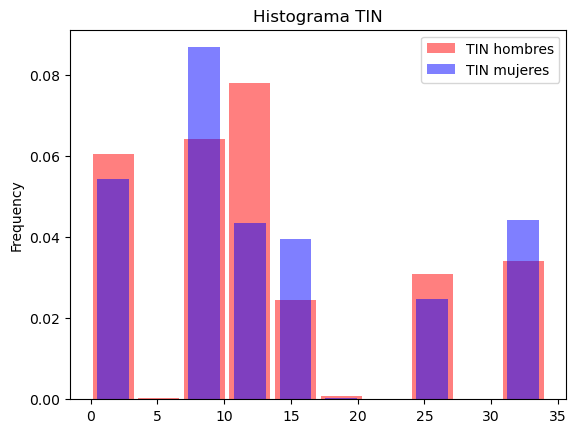

In [74]:
h1 = tin_hombres.plot.hist(density = True, alpha = 0.5, rwidth = 0.9, color = "red", legend = True, title = "Histograma TIN")
h2 = tin_mujeres.plot.hist(density = True, alpha = 0.5, rwidth = 0.7, color = "blue", legend = True)

#Ambos histogramas estan representados en una frecuencia relativa para que la comparativa sea correcta.

In [75]:
tin_hombres.describe() > tin_mujeres.describe()

#Hay mas datos disponibles para los hombres que para las mujeres

#La media del tin de los hombres es inferior a la de las mujeres.

#La mediana del tin de los hombres es superior a la de las mujeres.

count     True
mean     False
std      False
min      False
25%      False
50%       True
75%      False
max      False
dtype: bool

#### 3.4. ¿Cual es la tendencia de la tasa de aprobación en el tiempo (por días) y qué factores crees que han influido?

In [76]:
finance_df["operationdate"]

0      2019-01-12 07:22:30
1      2019-01-15 09:31:53
2      2019-01-12 07:21:41
3      2019-01-15 09:29:20
4      2019-01-15 09:32:01
               ...        
2439   2019-01-11 16:39:40
2440   2019-01-15 19:12:28
2441   2019-01-11 12:30:59
2442   2019-01-10 01:07:20
2443   2019-01-10 03:34:49
Name: operationdate, Length: 2444, dtype: datetime64[ns]

In [77]:
finance_df_ordenado = finance_df.sort_values("operationdate") #se ordenan los datos por orden de fecha
finance_df_ordenado

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
15,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:12:27,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
21,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:12:28,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
26,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:12:40,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
34,type_1,2019-01-01,5c2f4adbbb28a700012b89cd,2019-01-10 00:12:42,3c83c1df9568e45cc35af62f2e438549,11.95,status_1,0.009500,NaN,1,Sevilla,22,DOG
14,type_1,2019-01-01,5c2f4adbbb28a700012b89cd,2019-01-10 00:14:24,3c83c1df9568e45cc35af62f2e438549,11.95,status_1,0.009500,NaN,1,Sevilla,22,DOG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,type_1,2019-01-01,5c3751b3a2ca485f0e4278e5,2019-01-15 23:25:20,04875f6f3b84d5c5713abf2734ac4100,11.95,status_1,0.009865,NaN,1,Sevilla,43,FEMALE
1103,type_1,2019-01-01,5c374076a2ca485f0e4263c6,2019-01-15 23:29:20,9a88fdd19919cfcdb661afe4b7b5032d,7.25,status_2,0.008848,False,1,Valencia,37,DOG
522,type_1,2019-01-01,5c3e6dcea2ca485f0e457fab,2019-01-15 23:33:35,03a3a343858a88f38228bc85dcce3a10,24.00,status_1,0.008211,NaN,1,Valencia,42,DOG
2432,type_1,2019-01-01,5c36f300a2ca485f0e4174de,2019-01-15 23:52:17,f4ce9630c6cd2d426e9a053f0d430559,11.95,status_1,0.008830,NaN,0,Barna,59,MALE


In [94]:
finance_df_ordenado = finance_df_ordenado.set_index(finance_df_ordenado["operationdate"]).to_period('d')
finance_df_ordenado
#se toma como indice la fecha por dias

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef,is_ok_gdpr,CCAA,age,sex
operationdate,,,,,,,,,,,,,
2019-01-10,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:12:27,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
2019-01-10,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:12:28,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
2019-01-10,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,2019-01-10 00:12:40,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1,Sevilla,22,DOG
2019-01-10,type_1,2019-01-01,5c2f4adbbb28a700012b89cd,2019-01-10 00:12:42,3c83c1df9568e45cc35af62f2e438549,11.95,status_1,0.009500,NaN,1,Sevilla,22,DOG
2019-01-10,type_1,2019-01-01,5c2f4adbbb28a700012b89cd,2019-01-10 00:14:24,3c83c1df9568e45cc35af62f2e438549,11.95,status_1,0.009500,NaN,1,Sevilla,22,DOG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-15,type_1,2019-01-01,5c3751b3a2ca485f0e4278e5,2019-01-15 23:25:20,04875f6f3b84d5c5713abf2734ac4100,11.95,status_1,0.009865,NaN,1,Sevilla,43,FEMALE
2019-01-15,type_1,2019-01-01,5c374076a2ca485f0e4263c6,2019-01-15 23:29:20,9a88fdd19919cfcdb661afe4b7b5032d,7.25,status_2,0.008848,False,1,Valencia,37,DOG
2019-01-15,type_1,2019-01-01,5c3e6dcea2ca485f0e457fab,2019-01-15 23:33:35,03a3a343858a88f38228bc85dcce3a10,24.00,status_1,0.008211,NaN,1,Valencia,42,DOG


In [79]:
#tasa de aprobados diaria = (numero de aprobados en un dia/ prestatarios en un dia) *100

numero_de_aprobados = finance_df_ordenado["status"] == "status_OK"
numero_de_aprobados

operationdate
2019-01-10     True
2019-01-10     True
2019-01-10     True
2019-01-10    False
2019-01-10    False
              ...  
2019-01-15    False
2019-01-15    False
2019-01-15    False
2019-01-15    False
2019-01-15    False
Freq: D, Name: status, Length: 2444, dtype: bool

In [80]:
tasa_de_aprobados_diaria = numero_de_aprobados.groupby(level = 0).mean()*100
#tasa de aprobados diaria = (numero de aprobados en un dia/ prestatarios en un dia) *100
tasa_de_aprobados_diaria.name = "Tasa diaria de aprobados" 
tasa_de_aprobados_diaria

#se agrupan los valores por dia y se hace la media


operationdate
2019-01-10    20.266272
2019-01-11    38.957055
2019-01-12    27.906977
2019-01-13    34.090909
2019-01-14    15.167549
2019-01-15    30.578512
Freq: D, Name: Tasa diaria de aprobados, dtype: float64

In [81]:
media = tasa_de_aprobados_diaria.mean()
media = pd.Series(media, index = tasa_de_aprobados_diaria.index)
media.name = "Media diaria de la tasa de aprobados"
media

operationdate
2019-01-10    27.827879
2019-01-11    27.827879
2019-01-12    27.827879
2019-01-13    27.827879
2019-01-14    27.827879
2019-01-15    27.827879
Freq: D, Name: Media diaria de la tasa de aprobados, dtype: float64

In [82]:
tendencia = pd.concat([tasa_de_aprobados_diaria, media], axis = 1)
tendencia

,Tasa diaria de aprobados,Media diaria de la tasa de aprobados
operationdate,,
2019-01-10,20.266272,27.827879
2019-01-11,38.957055,27.827879
2019-01-12,27.906977,27.827879
2019-01-13,34.090909,27.827879
2019-01-14,15.167549,27.827879
2019-01-15,30.578512,27.827879


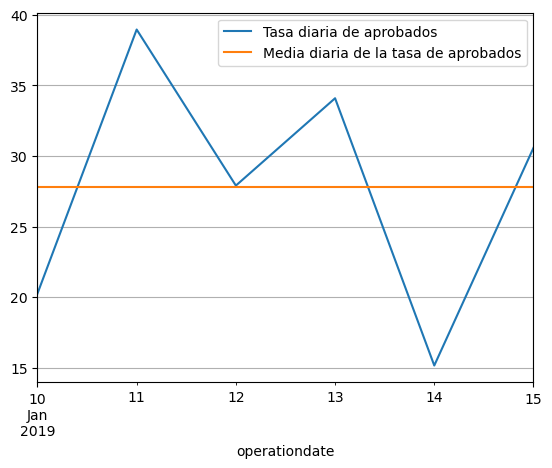

In [83]:
grafico1 = tendencia.plot(grid = 'on', legend = True, )

# Parte 4: Conclusiones sobre los datos obtenidos 

Trata de sacar un insight/conclusión de cualquier dataframe de los que has ido sacando o de la tabla con la que has comenzado la prueba y realiza al menos una visualización con cualquier librería de visualización con la que te sientas cómodo (matplotlib, bokeh...). Comenta los pasos que sigues para ello.

In [84]:
finance_df1 #se utilizan los datos del primer DataFrame

,type,month_partition,id,operationdate,userid,tin,status,rand_score,isinasnef
0,type_1,2019-01-01,5c36f18da2ca485f0e416381,2019-01-10 18:20:22,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
1,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,2019-01-12 12:25:24,67cca20b6c1bf628a9c25512a314f5a6,0.00,status_KO,0.008948,False
2,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,2019-01-12 07:22:30,a2d37424b520e898e098097146d20441,34.10,status_2,0.011019,False
3,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,2019-01-14 16:32:46,a6acd91cf19028aca95f329940d693ce,0.00,status_1,0.013384,False
4,type_3,2019-01-01,5c3cbb29330b80001637c728,2019-01-15 11:13:56,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...,...
9204,type_2,2019-01-01,5c39ce33a2ca485f0e441e3b,2019-01-12 13:49:11,2e52c9c6cb53677e14b9eabcefc9c5f7,0.00,status_OK,0.009930,False
9205,type_1,2019-01-01,5c36f79fa2ca485f0e41a592,2019-01-10 22:29:23,85aad98b0fe308c0626fa9b84a1f6ffd,7.25,status_1,0.008372,NaN
9206,type_1,2019-01-01,5c36eb52a2ca485f0e41448d,2019-01-10 18:35:51,cb64d8dc5c881c58d8402be4a1cca105,7.25,status_1,0.008753,NaN
9207,type_1,2019-01-01,5c37773da2ca485f0e42a36e,2019-01-11 14:25:18,f8b771b9f5b5ff03277699af78865ad8,34.10,status_KO,0.037637,False


In [85]:
#Se quiere saber cuantas operaciones se han registrado por hora

finance_df1 = finance_df1.set_index("operationdate").to_period("h") #se utiliza operationdate como un indice por hora
finance_df1

,type,month_partition,id,userid,tin,status,rand_score,isinasnef
operationdate,,,,,,,,
2019-01-10 18:00,type_1,2019-01-01,5c36f18da2ca485f0e416381,d865ae425b4e1d08dbb2ca2d171d9565,7.25,status_1,0.008384,NaN
2019-01-12 12:00,type_2,2019-01-01,5c3738a7a2ca485f0e425a11,67cca20b6c1bf628a9c25512a314f5a6,0.00,status_KO,0.008948,False
2019-01-12 07:00,type_1,2019-01-01,5c399530a2ca485f0e43ef6e,a2d37424b520e898e098097146d20441,34.10,status_2,0.011019,False
2019-01-14 16:00,type_2,2019-01-01,5c37a90ba2ca485f0e42e1e5,a6acd91cf19028aca95f329940d693ce,0.00,status_1,0.013384,False
2019-01-15 11:00,type_3,2019-01-01,5c3cbb29330b80001637c728,dd9582b9bb8eb183b9e5d1bb7e58bdda,10.95,status_OK,0.022400,False
...,...,...,...,...,...,...,...,...
2019-01-12 13:00,type_2,2019-01-01,5c39ce33a2ca485f0e441e3b,2e52c9c6cb53677e14b9eabcefc9c5f7,0.00,status_OK,0.009930,False
2019-01-10 22:00,type_1,2019-01-01,5c36f79fa2ca485f0e41a592,85aad98b0fe308c0626fa9b84a1f6ffd,7.25,status_1,0.008372,NaN
2019-01-10 18:00,type_1,2019-01-01,5c36eb52a2ca485f0e41448d,cb64d8dc5c881c58d8402be4a1cca105,7.25,status_1,0.008753,NaN


In [86]:
finance_df1 = finance_df1.sort_index() #se ordena el indice de forma ascendente
finance_df1

,type,month_partition,id,userid,tin,status,rand_score,isinasnef
operationdate,,,,,,,,
2019-01-10 00:00,type_1,2018-12-01,5c0f3c39a2ca485f0e38b68b,8a3ca84c1bf7a1aa74fd371ffc6e111e,12.95,status_1,0.010410,True
2019-01-10 00:00,type_1,2019-01-01,5c3693b83ffcdb0001017593,35f6963135b4962f2f37effe87a2d988,13.95,status_1,0.012800,NaN
2019-01-10 00:00,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False
2019-01-10 00:00,type_1,2018-12-01,5c113cd0a2ca485f0e3b1230,6705270299753801e5fffee8aa9e2012,17.95,status_1,0.017143,NaN
2019-01-10 00:00,type_1,2019-01-01,5c367fe4bb28a700012bc719,b992d85176bbf2608d1732a7f977ef8c,7.95,status_1,0.008400,NaN
...,...,...,...,...,...,...,...,...
2019-01-15 23:00,type_1,2019-01-01,5c3e72a93ffcdb000102b08f,6cdfa351f40c2e788fff4049a6a83414,16.95,status_1,0.020600,NaN
2019-01-15 23:00,type_1,2019-01-01,5c3ca72ea2ca485f0e450093,1889ca41dd17f8a0989accfda5478a31,24.00,status_1,0.010460,False
2019-01-15 23:00,type_1,2019-01-01,5c39030da2ca485f0e43d400,569a65d4e5defa3cd5b294a41112c9c6,24.00,status_OK,0.017773,False


In [87]:
finance_df1["n_operaciones"] = 1 #creo una columna de 1 
finance_df1

,type,month_partition,id,userid,tin,status,rand_score,isinasnef,n_operaciones
operationdate,,,,,,,,,
2019-01-10 00:00,type_1,2018-12-01,5c0f3c39a2ca485f0e38b68b,8a3ca84c1bf7a1aa74fd371ffc6e111e,12.95,status_1,0.010410,True,1
2019-01-10 00:00,type_1,2019-01-01,5c3693b83ffcdb0001017593,35f6963135b4962f2f37effe87a2d988,13.95,status_1,0.012800,NaN,1
2019-01-10 00:00,type_2,2019-01-01,5c2f4af5a2ca485f0e40462f,3c83c1df9568e45cc35af62f2e438549,0.00,status_OK,0.009500,False,1
2019-01-10 00:00,type_1,2018-12-01,5c113cd0a2ca485f0e3b1230,6705270299753801e5fffee8aa9e2012,17.95,status_1,0.017143,NaN,1
2019-01-10 00:00,type_1,2019-01-01,5c367fe4bb28a700012bc719,b992d85176bbf2608d1732a7f977ef8c,7.95,status_1,0.008400,NaN,1
...,...,...,...,...,...,...,...,...,...
2019-01-15 23:00,type_1,2019-01-01,5c3e72a93ffcdb000102b08f,6cdfa351f40c2e788fff4049a6a83414,16.95,status_1,0.020600,NaN,1
2019-01-15 23:00,type_1,2019-01-01,5c3ca72ea2ca485f0e450093,1889ca41dd17f8a0989accfda5478a31,24.00,status_1,0.010460,False,1
2019-01-15 23:00,type_1,2019-01-01,5c39030da2ca485f0e43d400,569a65d4e5defa3cd5b294a41112c9c6,24.00,status_OK,0.017773,False,1


In [88]:
n_operaciones = finance_df1["n_operaciones"].groupby(level = 0).sum()
#se agrupa la columna creada por hora sumando los valores de la misma
n_operaciones

operationdate
2019-01-10 00:00    29
2019-01-10 01:00    13
2019-01-10 02:00    10
2019-01-10 03:00     2
2019-01-10 04:00     5
                    ..
2019-01-15 19:00    82
2019-01-15 20:00    98
2019-01-15 21:00    64
2019-01-15 22:00    35
2019-01-15 23:00    52
Freq: H, Name: n_operaciones, Length: 144, dtype: int64

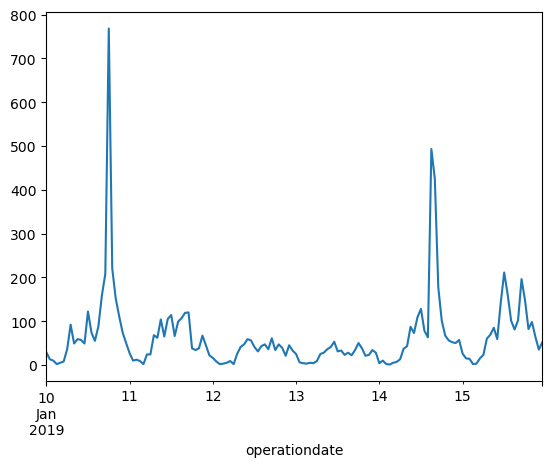

In [89]:
grafico = n_operaciones.plot()
#se grafican los valores obtenidos que representan el numero de operaciones por hora